In [1]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer, models, losses, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from foe_foundry_nl.data.training import load_triplet_loss_dataset
from pathlib import Path
import torch
from pprint import pprint
import numpy as np
import plotly.express as px
import plotly
import seaborn as sns
from foe_foundry import CreatureType
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import imageio

sns.set_style("whitegrid")
sns.set_palette("hls", len(CreatureType.all()))

palette = sns.color_palette("hls", len(CreatureType.all()))
palette_hex = palette.as_hex()


In [2]:
print("Generating triplet training data...")
dataset = load_triplet_loss_dataset()
n_train = len(dataset["train"])
n_test = len(dataset["test"])
n_eval = len(dataset["eval"])
print(f"Loaded dataset with {n_train} training samples, {n_test} test samples, and {n_eval} evaluation samples.")

Generating triplet training data...
Could not find hard negatives for haladron
Could not find hard negatives for pelagic_deva
Could not find hard negatives for psychopomp_angel
Could not find hard negatives for shrouded_angel
Could not find hard negatives for zirnitran
Could not find hard negatives for ursan_archon
Could not find hard negatives for centaurs
Could not find hard negatives for duffel_crab
Could not find hard negatives for razorback_crab
Could not find hard negatives for balbazu
Could not find hard negatives for kogukhpak
Could not find hard negatives for leech_demon
Could not find hard negatives for maha
Could not find hard negatives for vetala
Could not find hard negatives for devilflame_juggler
Could not find hard negatives for infernal_tutor
Could not find hard negatives for infernal_tutor_lesser
Could not find hard negatives for moldering_devil
Could not find hard negatives for rimepacted_devil
Could not find hard negatives for guardian_archaeopteryx
Could not find ha

In [ ]:
## TRAIN MODEL

fine_tuned_mlm_dir = Path.cwd().parent / "models" / "minilm-finetuned"
# tokenizer = AutoTokenizer.from_pretrained(fine_tuned_mlm_dir)
mlm_model = AutoModel.from_pretrained(fine_tuned_mlm_dir)


# Create a tokenization module for SentenceTransformer
word_embedding_model = models.Transformer(
    model_name_or_path=str(fine_tuned_mlm_dir),
    max_seq_length=512  # Optional: Set max sequence length
)

pooling_layer = models.Pooling(
    word_embedding_dimension=mlm_model.config.hidden_size,
    pooling_mode_mean_tokens=True,  # use mean pooling for embedding
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_layer])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_train_epochs = 3
train_batch_size = 32
total_steps = (n_train // train_batch_size) * num_train_epochs
warmup_steps = total_steps // 10

train_loss = losses.TripletLoss(
    model=model,
    distance_metric=losses.TripletDistanceMetric.COSINE,
    triplet_margin=0.3,
)

fine_tuned_st_dir = Path.cwd().parent / "models" / "minilm-finetuned-st"
trainer = SentenceTransformerTrainer(
    model=model,
    args=SentenceTransformerTrainingArguments(
        output_dir=str(fine_tuned_st_dir),
        overwrite_output_dir=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_strategy="steps",
        logging_steps=100,
        save_total_limit=2,  # Only save the last two models
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=2 * train_batch_size,
        learning_rate=5e-5,
        lr_scheduler_type="cosine",
        warmup_steps=warmup_steps,
        load_best_model_at_end=True,

        weight_decay = 0.02,  # similar to l2 regularization
    ),
    loss=train_loss,
    train_dataset=dataset["train"],
    eval_dataset=dataset["eval"],
)

print("Fine-Tuning Model...")
trainer.train(resume_from_checkpoint=True)

print(f"Saving Model to {fine_tuned_st_dir}...")
model.save(str(fine_tuned_st_dir))

print("Test Metrics:")
test_metrics = trainer.evaluate(dataset["test"])
pprint(test_metrics)

In [4]:
## LOAD MODEL

print("Loading Fine-Tuned Model...")
fine_tuned_st_dir = Path.cwd().parent.parent / "models" / "minilm-finetuned-st"
model = SentenceTransformer(str(fine_tuned_st_dir))

Loading Fine-Tuned Model...


In [5]:
from foe_foundry_nl.data.monsters2 import get_monsters
from foe_foundry import CreatureType
from tqdm.notebook import tqdm

rng = np.random.default_rng(20210518)

# generate mean embeddings for each monster
monsters = get_monsters()

keys = []
embeddings = []
is_srd = []
creature_types = []
crs = []
acs = []
hps = []

with tqdm(total=len(monsters)) as pbar:
    for key, monster in monsters.items():
        paragraphs = [paragraph for _, paragraph in monster.iter_paragraphs(rng)]
        monster_embeddings = [model.encode(paragraph) for paragraph in paragraphs]

        embedding = np.mean(monster_embeddings, axis=0)
        keys.append(key)
        embeddings.append(embedding)
        is_srd.append(monster.srd)
        creature_types.append(monster.creature_type)
        crs.append(monster.cr_numeric)
        acs.append(monster.ac)
        hps.append(monster.hp)
        pbar.update(1)


keys = np.array(keys)
embeddings = np.array(embeddings)
is_srd = np.array(is_srd, dtype=bool)
creature_types = np.array(creature_types)
crs = np.array(crs)
acs = np.array(acs)
hps = np.array(hps)

crs_scaled = (crs - crs.min()) / (crs.max() - crs.min())
acs_scaled = (acs - acs.min()) / (acs.max() - acs.min())
hps_scaled = (hps - hps.min()) / (hps.max() - hps.min())

ct_lookup = {ct.value: i for i, ct in enumerate(CreatureType.all()) }

creature_type_one_hot = np.zeros((len(keys), len(ct_lookup)), dtype=int)
for i, creature_type in enumerate(creature_types):
    ct_index =ct_lookup[creature_type]
    creature_type_one_hot[i, ct_index] = 1



  0%|          | 0/2203 [00:00<?, ?it/s]

c:\code\foe_foundry\.venv\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


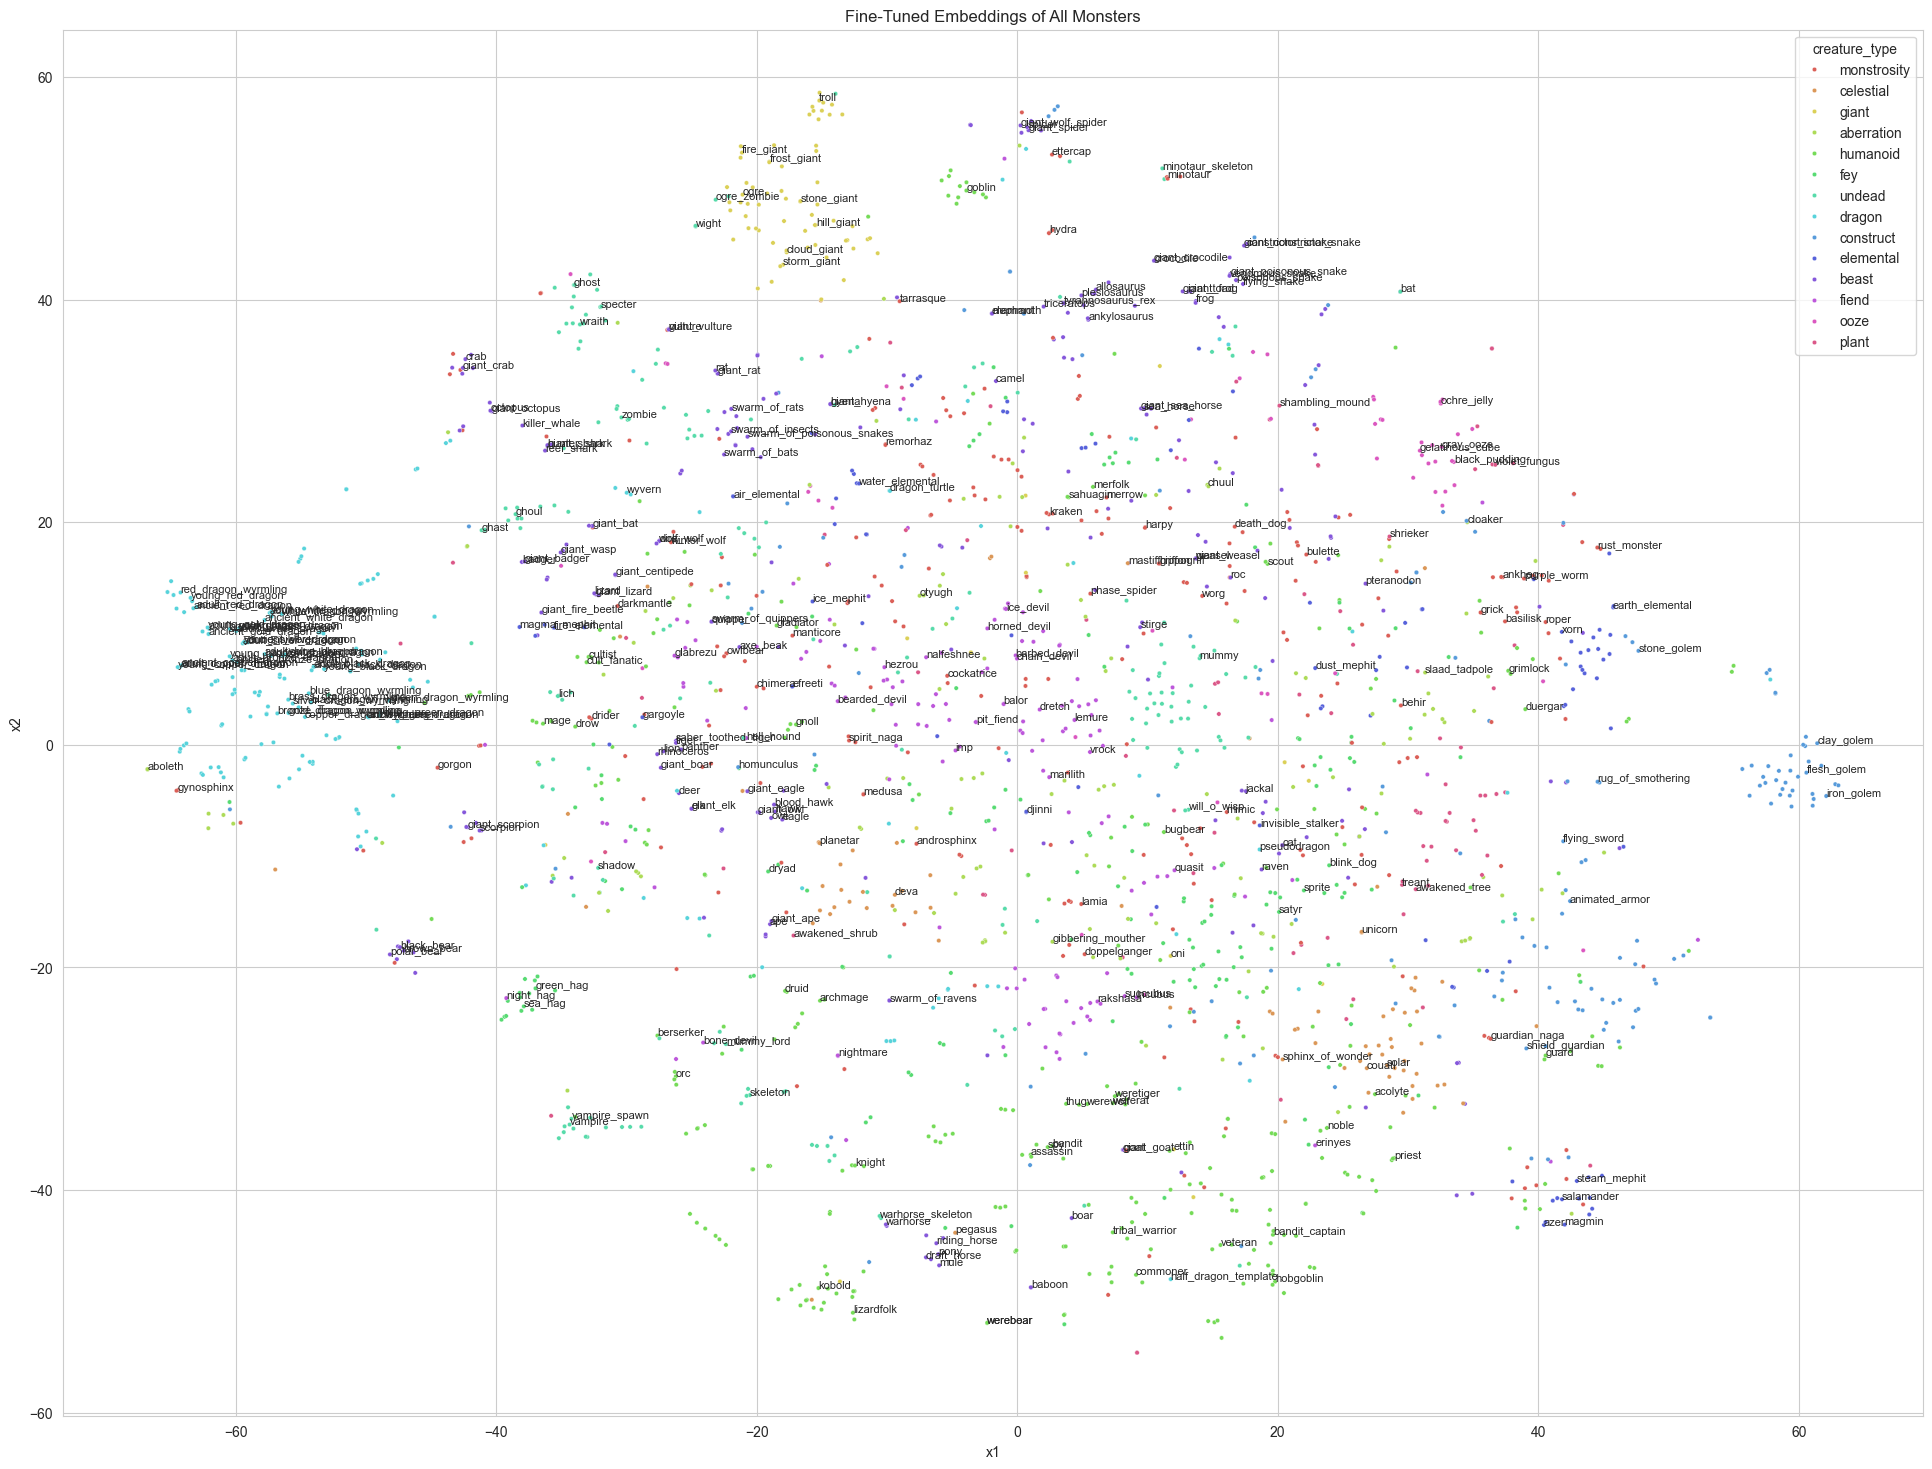

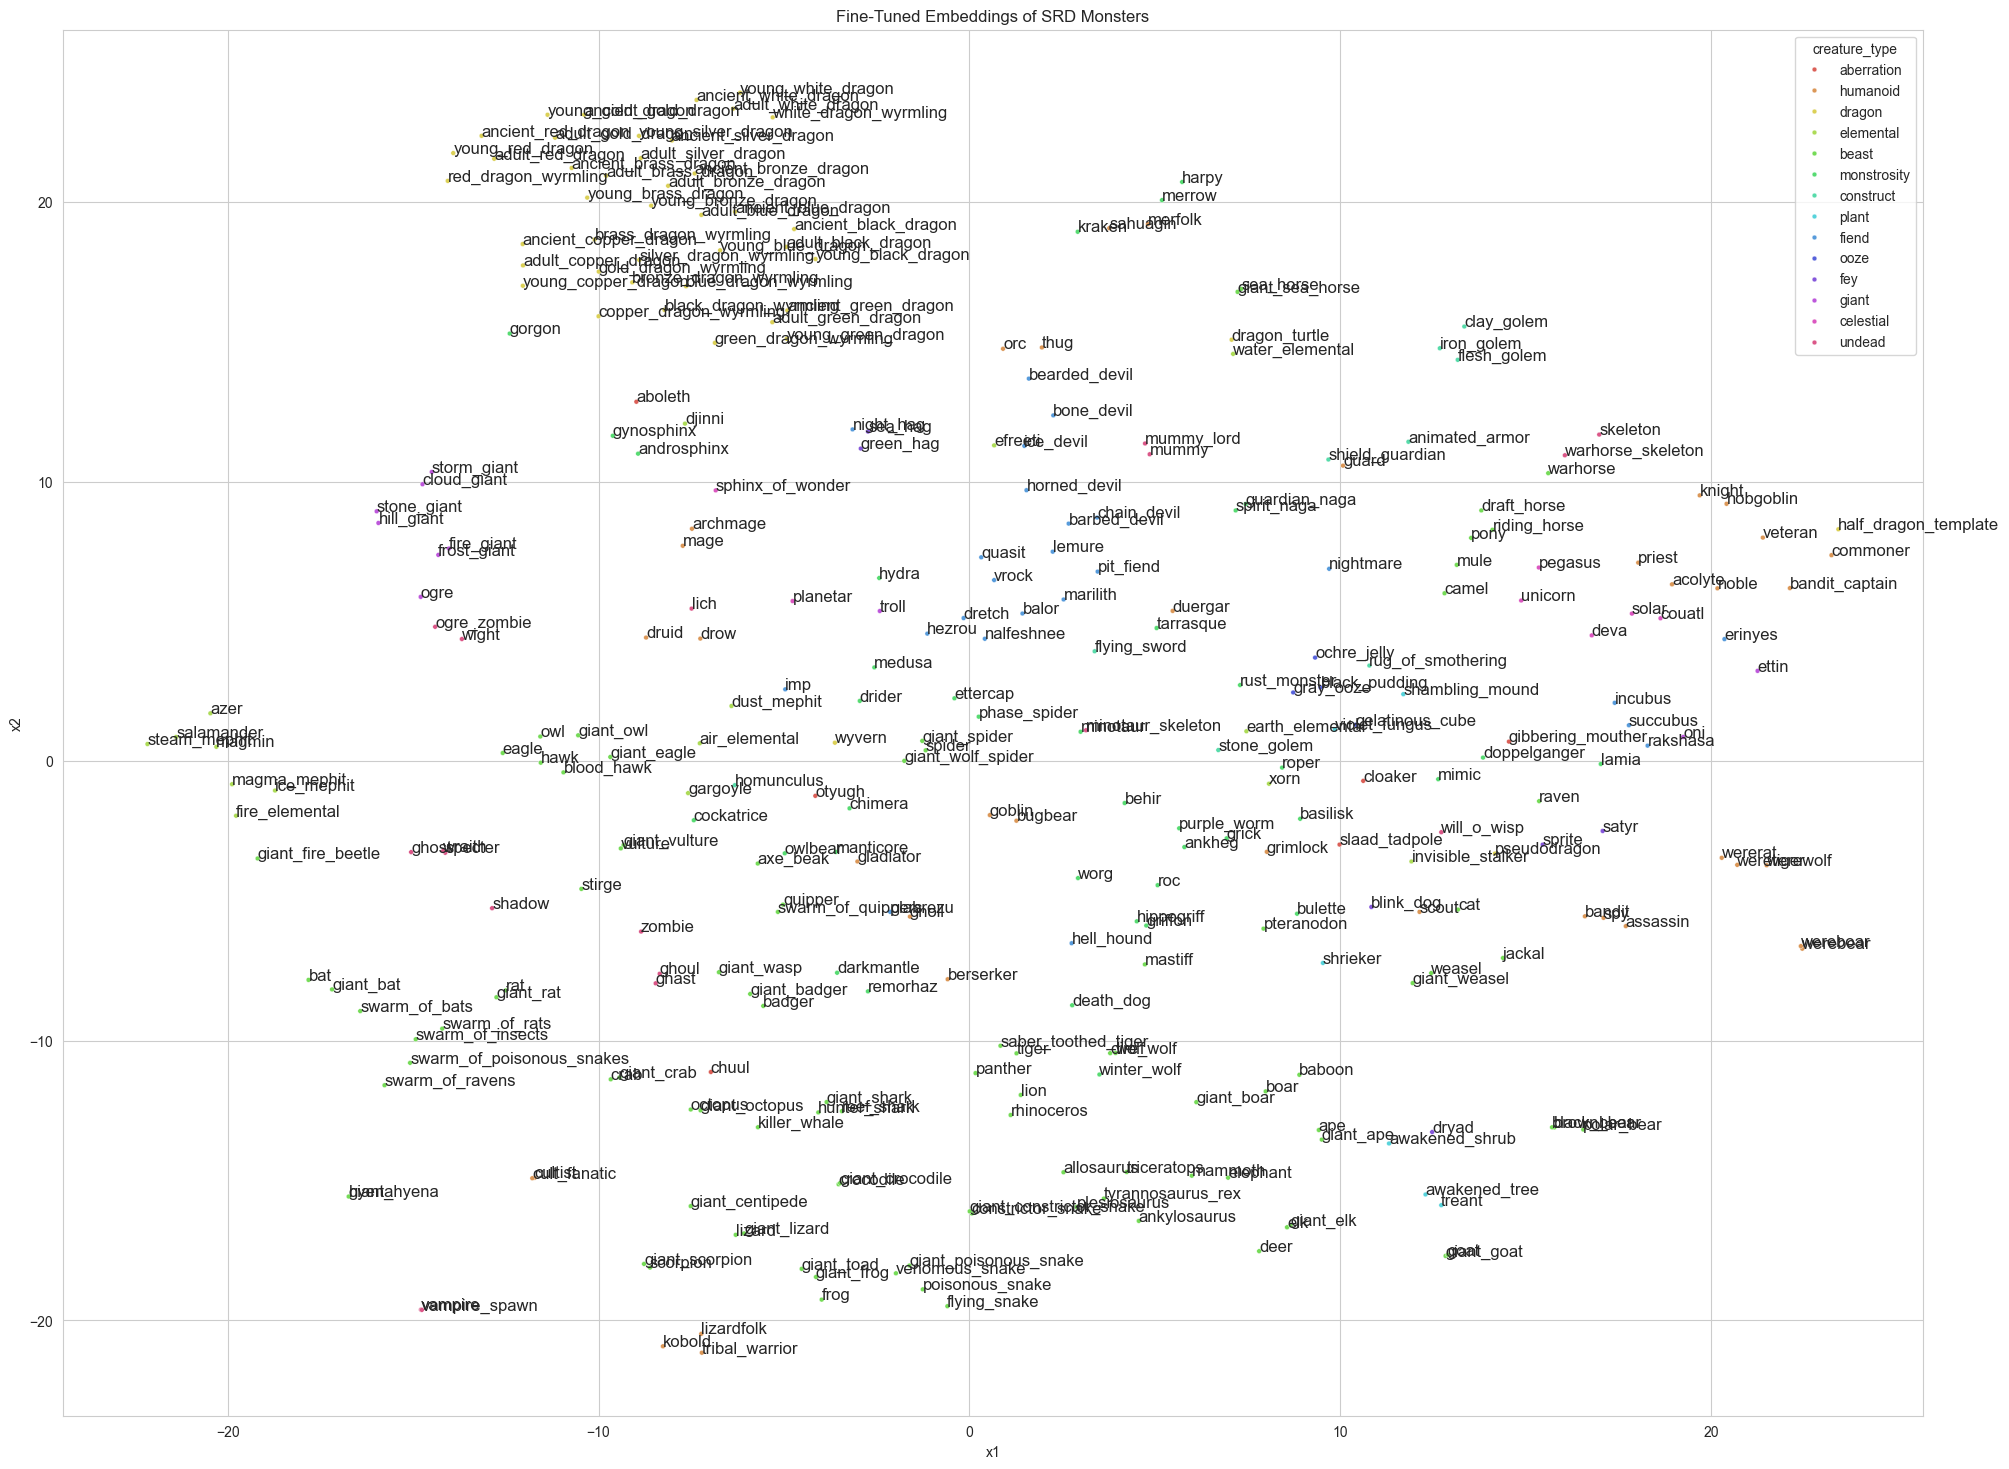

In [6]:

# embeddings_extended = np.concatenate([embeddings, crs_scaled[:, None], acs_scaled[:, None], hps_scaled[:, None], creature_type_one_hot], axis=1)
srd_embeddings = embeddings[is_srd]
srd_keys = keys[is_srd]
srd_creature_types = creature_types[is_srd]


tsne = TSNE(n_components=2, random_state=20240711)
X_all = tsne.fit_transform(embeddings)
X_srd = tsne.fit_transform(srd_embeddings)


## ALL MONSTERS - SEABORN

df = pd.DataFrame([
    pd.Series(X_all[:, 0], name='x1'),
    pd.Series(X_all[:, 1], name='x2'),
    pd.Series(creature_types, name='creature_type')
]).T

fig, ax = plt.subplots(1,1, figsize=(24,18))
sns.scatterplot(
    data=df,
    x='x1',
    y='x2',
    hue='creature_type',
    ax=ax,
    s=10
)

for index in np.where(is_srd)[0]:
    name = str(keys[index])
    x = float(X_all[index, 0])
    y = float(X_all[index, 1])
    ax.annotate(name, (x, y), size=8)

ax.set_title("Fine-Tuned Embeddings of All Monsters")


## SRD MONSTERS - SEABORN

df = pd.DataFrame([
    pd.Series(X_srd[:, 0], name='x1'),
    pd.Series(X_srd[:, 1], name='x2'),
    pd.Series(srd_creature_types, name='creature_type')
]).T

fig, ax = plt.subplots(1,1, figsize=(24,18))
sns.scatterplot(
    data=df,
    x='x1',
    y='x2',
    hue='creature_type',
    ax=ax,
    s=12
)

for index, name in enumerate(srd_keys):
    x = float(X_srd[index, 0])
    y = float(X_srd[index, 1])
    ax.annotate(name, (x, y), size=12)

ax.set_title("Fine-Tuned Embeddings of SRD Monsters")

## ALL MONSTERS - PLOTLY

df = pd.DataFrame([
    pd.Series(keys, name='monster'),
    pd.Series(X_all[:, 0], name='x1'),
    pd.Series(X_all[:, 1], name='x2'),
    pd.Series(creature_types, name='creature_type'),
    pd.Series(is_srd, name='is_srd'),
    pd.Series(crs, name='cr')
]).T



fig = px.scatter(
    df,
    x='x1',
    y='x2',
    color='creature_type',
    hover_data=['monster', 'is_srd', 'cr'],
    title="Fine-Tuned Embeddings of SRD Monsters",
    color_discrete_sequence=palette_hex
)
for index, (name, srd) in enumerate(zip(keys, is_srd)):
    if srd:
        fig.add_annotation(
            x=float(X_all[index, 0]),
            y=float(X_all[index, 1]),
            text=name,
            showarrow=False,
            font=dict(size=10, color='rgba(0,0,0,0.7)'),
        )
fig.update_layout(
    width=1200,
    height=900
)
fig.show()



In [7]:
## ALL MONSTERS - 3D - PLOTLY

tsne = TSNE(n_components=3, random_state=20240711)

X_3d = tsne.fit_transform(embeddings)
# sizes_3d = 3 * (is_srd.astype('int32') + np.ones_like(is_srd))

sizes_3d = np.log(crs + 3) * 3

df = pd.DataFrame({
    'monster': keys,
    'x': [point[0] for point in X_3d],
    'y': [point[1] for point in X_3d],
    'z': [point[2] for point in X_3d],
    'creature_type': creature_types,
    'is_srd': is_srd,
    'cr': crs,
    'size': sizes_3d
})

fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    size='size',
    symbol='is_srd',
    color='creature_type',
    hover_data=['monster', 'is_srd', 'cr'],
    title="Fine-Tuned Embeddings of All Monsters",
    opacity=0.7,
    color_discrete_sequence=palette_hex
)


def filter_legend(trace):
    if ", False" in trace.name:
        trace.update(showlegend=False)
    else:
        new_name = trace.name.split(",")[0]
        trace.update(name=new_name)

# Hide the legend for 'is_srd'
fig.for_each_trace(filter_legend)


# for index, (name, srd) in enumerate(zip(keys, is_srd)):
#     if srd:
#         fig.add_annotation(
#             x=float(X_3d[index, 0]),
#             y=float(X_3d[index, 1]),
#             z=float(X_3d[index, 2]),
#             text=name,
#             showarrow=False,
#             font=dict(size=10, color='rgba(0,0,0,0.7)'),
#         )


fig.update_layout(
    width=1200,
    height=900,
    margin=dict(l=0, r=0, b=0, t=0)
)
fig.show()




In [12]:
# Function to capture frames
def capture_frames(fig, angles, filename="rotation.gif"):
    frames = []

    with tqdm(total=len(angles)) as pbar:
        for angle in angles:
            fig.update_layout(scene_camera_eye=dict(x=np.cos(angle), y=np.sin(angle), z=0.5))
            img_bytes = plotly.io.to_image(fig, format="png", scale=0.8)
            frames.append(imageio.imread(img_bytes))
            pbar.update(1)
    imageio.mimsave(filename, frames, fps=10, loop=0)

# Define angles for rotation
angles = np.linspace(0, 2 * np.pi, 6*18)

# Capture frames and save as GIF
capture_frames(fig, angles, filename="rotation.gif")

  0%|          | 0/108 [00:00<?, ?it/s]

C:\Users\evanr\AppData\Local\Temp\ipykernel_23852\1033731022.py:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

